In [554]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 


import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy.spatial import distance
from sklearn.metrics.pairwise import nan_euclidean_distances

from matplotlib.lines import Line2D
from matplotlib import rcParams, cycler
from sklearn.preprocessing import PowerTransformer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [555]:
import warnings
warnings.filterwarnings("ignore")

In [556]:
def initialize(threshold, start_time):
    PM25 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/PM25")

    times = pd.date_range(start=start_time, end='2018-12-31 23:00:00', freq='30Min') #one less because the last is always nan

    start_idx = PM25.shape[0]-times.shape[0]

    # remove the last index as it is always nan
    PM25 = PM25[:-1]
    times = times[:-1]

    # reduced PM25 
    r_PM25 = PM25[start_idx:] 
    idx = r_PM25.notnull().sum(axis = 0)/r_PM25.shape[0]>threshold
    r_PM25 = r_PM25.loc[:, idx]

    r_PM25.reset_index(inplace=True)
    r_PM25.drop(labels = 'index',axis=1, inplace=True)
    
    return times, r_PM25


In [562]:
threshold = 0.6 # how much non-missing values are in the time-series in order to include the station?
start_time = '2013-01-01 00:00:00'
times, r_PM25 = initialize(threshold, start_time)

In [566]:
# # for R - check for MCAR/MAR... 
# imp = IterativeImputer(max_iter=1,estimator=ExtraTreesRegressor(n_estimators=10,random_state=0),verbose=True) 
# imp.fit(r_PM25) # fit based on the data

# imputed_df = imp.transform(r_PM25) # impute it
# imputed_df = pd.DataFrame(imputed_df, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe

# # r_PM25.to_csv('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/r_PM25_forR.csv', sep=' ', index=False, header=False, na_rep='NA')
# # imputed_df.to_csv('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/imputed_df_forR.csv', sep=' ', index=False, header=False, na_rep='NA')


In [407]:
# null percentages
# r_PM25.shape[1]
# 1-r_PM25.notnull().sum(axis = 0)/r_PM25.shape[0]
# r_PM25.shape[0]
# r_PM25.shape[1]
# r_PM25.shape[1]*r_PM25.shape[0]

# Functions

In [534]:
# keep the division of the CV identical to compare different algorithms. 
rnd_state_forCV = 0

In [535]:
# out of all non-nan indexes, perform 10-fold cross validation.
# the test is y_missing. copy r_PM25, put all null inside, and assign values from r_PM25 according to test indexes. 
# the train is X_missing. copy r_PM25, and assign nans according to test indexes. 
# the splitting currently doesn't try to preserve the original relative missing intervals
# of each feature. maybe I will add it somehow later. 

def KFold_cross_validation(imp,PM25,k,withDays):
    
    if withDays:
        wd = PM25['week day']
        m = PM25['month']
        h = PM25['hour']
        PM25.drop(['week day','month','hour'],axis=1,inplace=True)
        
    kf = KFold(n_splits=k, random_state=rnd_state_forCV, shuffle=True)
    not_nan_idx = np.argwhere(PM25.notnull().values)
    results = []
    
    for i, (train_index, test_index) in enumerate(kf.split(not_nan_idx)):
        if i==9:  
            
            np_PM25 = PM25.values
            
            
#             if normalize:
#             # change X_missing to normal_data
#                 pt = PowerTransformer(method='box-cox')
#                 t_data = PM25.values+1
#                 pt.fit(t_data)

#                 # by default applies seperately to each column
#                 PM25 = pd.DataFrame(
#                     pt.transform(t_data),
#                     index=PM25.index,
#                     columns=PM25.columns)

                
            
            X_missing = PM25.copy()
            y_missing = PM25.copy()                
                

            # y_missing 
            y_missing.iloc[:] = np.nan
            np_y_missing = y_missing.values

            # asssign values according to test indexes
            rows, cols = zip(*not_nan_idx[test_index])
            vals = np_PM25[rows, cols]
            np_y_missing[rows, cols] = vals
            # turn back to dataframe
            y_missing = pd.DataFrame(np_y_missing,columns=PM25.columns)

            # X_missing
            # assign nans according to test indexes
            np_X_missing = X_missing.values
            np_X_missing[rows, cols] = np.nan

            # turn back to dataframe
            X_missing = pd.DataFrame(np_X_missing,columns=PM25.columns)

            
            
            
#             # ADDED - concat shifted dataframes +-1 time
#             shiftM1 = X_missing.shift(periods=-1)
#             shiftP1 = X_missing.shift(periods=1)
#             X_missing = pd.concat([shiftM1, X_missing, shiftP1],axis = 1)
     
        
            
            if withDays:
                X_missing['week day']=wd
                X_missing['hour']=h
                X_missing['month']=m

            # perform fit 
            imp.fit(X_missing)
            imputed_df = imp.transform(X_missing) # impute it
            imputed_df = pd.DataFrame(imputed_df, columns=X_missing.columns) #turn it from IterativeImputer object to a dataframe
            
            if withDays:
                imputed_df.drop(['week day','hour','month'],axis = 1, inplace=True)

            
            
            
#             # ADDED - 
#             imputed_df = pd.DataFrame(imputed_df.iloc[:,34:68].values, columns=PM25.columns)


#             if normalize:
#                 imputed_df = pd.DataFrame(
#                 pt.inverse_transform(imputed_df.values)-1,
#                 index=imputed_df.index,
#                 columns=imputed_df.columns)
            
            
            # evaluate
            y_train = vals
            np_imputed_df = imputed_df.values
            y_pred = np_imputed_df[rows, cols]

            # assign results
            RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
            MedianAE = median_absolute_error(y_train, y_pred)
            MeanAE = mean_absolute_error(y_train,y_pred)
            R2 = r2_score(y_train,y_pred)
            results.append([RMSE,MedianAE,MeanAE,R2])
  
# mark this if only run 1 cv:
#     results = pd.DataFrame(results, columns=['RMSE','MedianAE','MeanAE','R2'])
    print(results)
    return imputed_df
        
        

# (1) IterativeImputer with BayesianRidge and ExtraTreesRegressor

In [515]:
# not sure about the random_state! plus I've read that no need for CV in random forest.
# I think I ran it with max_iter=5 before, but not sure. 10 trees. 
rnd_state_forRF = 0 # I believe I should play with this parameter as well. 
# imp_RF = IterativeImputer(max_iter=3,estimator=ExtraTreesRegressor(n_estimators=10,random_state=rnd_state_forRF, n_jobs=-1),verbose=True) 
# imp_BR = IterativeImputer(max_iter=10,estimator=BayesianRidge(),verbose=True) 
# try also to change the initial imputer - mean/median/constant...
# and n_estimators (number of trees in the forest...)

## A - without days 

### dbda

In [371]:
results_woD_RF_dbda = KFold_cross_validation(imp_RF,r_PM25,k=10,withDays=False)

[IterativeImputer] Completing matrix with shape (105166, 102)
[IterativeImputer] Change: 15630.748167246573, scaled tolerance: 1.6975 
[IterativeImputer] Change: 2739.7199999999993, scaled tolerance: 1.6975 
[IterativeImputer] Change: 1502.92, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 102)
[IterativeImputer] Completing matrix with shape (105166, 102)
[IterativeImputer] Change: 15488.195350804976, scaled tolerance: 1.6975 
[IterativeImputer] Change: 2663.2199999999993, scaled tolerance: 1.6975 
[IterativeImputer] Change: 1924.2300000000005, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 102)
[IterativeImputer] Completing matrix with shape (105166, 102)
[IterativeImputer] Change: 13598.415126391215, scaled tolerance: 1.6975 
[IterativeImputer] Change: 1990.3499999999995, scaled tolerance: 1.6975 
[IterativeImputer] Change: 1413.06, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166

In [372]:
results_woD_RF_dbda

,RMSE,MedianAE,MeanAE,R2
0,6.435183,2.61,3.885057,0.923385
1,6.427738,2.61,3.877976,0.923910
2,6.447033,2.62,3.900998,0.925071
3,6.484012,2.62,3.887248,0.924545
4,6.511999,2.62,3.896328,0.924275
5,6.173801,2.60,3.858634,0.925917
6,6.520708,2.62,3.896496,0.915368
7,6.344937,2.61,3.880556,0.929574
8,6.611189,2.60,3.879706,0.922424
9,6.344548,2.61,3.875174,0.925233


In [373]:
results_woD_RF_dbda.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_RF_dbda")

### calculating all imputed matrixes that I didn't save:

In [694]:
# RF, without days, with dbda (= Addition 1)
imp_RF = IterativeImputer(max_iter=3,estimator=ExtraTreesRegressor(n_estimators=10,random_state=rnd_state_forRF, n_jobs=-1),verbose=True) 
RF_woD_dbda_cv10 = KFold_cross_validation(imp_RF,r_PM25,k=10,withDays=False)
RF_woD_dbda_cv10.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_woD_dbda_cv10")

[IterativeImputer] Completing matrix with shape (105166, 102)
[IterativeImputer] Change: 14749.36863968002, scaled tolerance: 1.6975 
[IterativeImputer] Change: 2379.7000000000003, scaled tolerance: 1.6975 
[IterativeImputer] Change: 2357.9600000000005, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 102)
[[6.283846641263802, 2.6099999999999994, 3.8780942736388493, 0.9266564334237868]]


In [695]:
r_PM25_withDays = r_PM25.copy()
r_PM25_withDays['week day'] = pd.to_datetime(times).dayofweek
r_PM25_withDays['month'] = pd.to_datetime(times).month
r_PM25_withDays['hour'] = pd.to_datetime(times).hour

In [696]:
# RF, with days, with dbda (= Addition 1+2)
imp_RF = IterativeImputer(max_iter=3,estimator=ExtraTreesRegressor(n_estimators=10,random_state=rnd_state_forRF, n_jobs=-1),verbose=True) 
RF_wD_dbda_cv10 = KFold_cross_validation(imp_RF,r_PM25_withDays,k=10,withDays=True)
RF_wD_dbda_cv10.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_wD_dbda_cv10")

[IterativeImputer] Completing matrix with shape (105166, 105)
[IterativeImputer] Change: 14591.822684480943, scaled tolerance: 1.6975 
[IterativeImputer] Change: 2510.91, scaled tolerance: 1.6975 
[IterativeImputer] Change: 1555.0799999999995, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 105)
[[6.271037060397436, 2.6199999999999974, 3.8703385099859124, 0.9269551494230673]]


In [ ]:
# NOW REMOVE THE CONCAT LINES IN CV FUNC:

In [602]:
# RF, without days
imp_RF = IterativeImputer(max_iter=5,estimator=ExtraTreesRegressor(n_estimators=10,random_state=rnd_state_forRF, n_jobs=-1),verbose=True) 
RF_woD_cv10 = KFold_cross_validation(imp_RF,r_PM25,k=10,withDays=False)
RF_woD_cv10.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_woD_cv10")

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 6325.825698057385, scaled tolerance: 1.6975 
[IterativeImputer] Change: 1090.0699999999995, scaled tolerance: 1.6975 
[IterativeImputer] Change: 861.8299999999999, scaled tolerance: 1.6975 
[IterativeImputer] Change: 925.3199999999999, scaled tolerance: 1.6975 
[IterativeImputer] Change: 763.7400000000002, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[[9.327683327736539, 4.0699999999999985, 5.744148404740201, 0.8383936366988755]]


In [349]:
# perform transformation to data 

In [371]:
# BR, without days
imp_BR = IterativeImputer(max_iter=10,estimator=BayesianRidge(),verbose=True) 
BR_woD_cv10 = KFold_cross_validation(imp_BR,r_PM25,k=10,withDays=False)
BR_woD_cv10.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/BR_woD_cv10")

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 6057.2178503293935, scaled tolerance: 1.6975 
[IterativeImputer] Change: 906.5548447621236, scaled tolerance: 1.6975 
[IterativeImputer] Change: 454.4946462317969, scaled tolerance: 1.6975 
[IterativeImputer] Change: 323.50036848219906, scaled tolerance: 1.6975 
[IterativeImputer] Change: 339.7106326368698, scaled tolerance: 1.6975 
[IterativeImputer] Change: 501.5519075954876, scaled tolerance: 1.6975 
[IterativeImputer] Change: 372.26295617987154, scaled tolerance: 1.6975 
[IterativeImputer] Change: 38.195642642071604, scaled tolerance: 1.6975 
[IterativeImputer] Change: 30.277524567145207, scaled tolerance: 1.6975 
[IterativeImputer] Change: 23.933339833613402, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[[11.814213852323215, 4.763853963073485, 6.96800496167793, 0.740748948794016]]


In [691]:
# KNN, without days
imp_KNN = IterativeImputer(max_iter=1,estimator=KNeighborsRegressor(n_neighbors=10,weights='distance',n_jobs=-1),verbose=True) 
KNN_woD_cv10 = KFold_cross_validation(imp_KNN,r_PM25,k=10,withDays=False)
KNN_woD_cv10.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/KNN_woD_cv10")

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 6118.17583507105, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[[9.46251695404636, 3.916427232911026, 5.547055589522322, 0.8336877605356547]]


In [521]:
r_PM25_withDays = r_PM25.copy()
r_PM25_withDays['week day'] = pd.to_datetime(times).dayofweek
r_PM25_withDays['month'] = pd.to_datetime(times).month
r_PM25_withDays['hour'] = pd.to_datetime(times).hour

In [522]:
# not sure it is necessary:
# RF, with days
imp_RF = IterativeImputer(max_iter=5,estimator=ExtraTreesRegressor(n_estimators=10,random_state=rnd_state_forRF, n_jobs=-1),verbose=True) 
RF_wD_cv10 = KFold_cross_validation(imp_RF,r_PM25_withDays,k=10,withDays=True)
RF_wD_cv10.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_wD_cv10")

[IterativeImputer] Completing matrix with shape (105166, 37)
[IterativeImputer] Change: 6634.705698057385, scaled tolerance: 1.6975 
[IterativeImputer] Change: 1494.5, scaled tolerance: 1.6975 
[IterativeImputer] Change: 675.47, scaled tolerance: 1.6975 
[IterativeImputer] Change: 914.3999999999996, scaled tolerance: 1.6975 
[IterativeImputer] Change: 635.0700000000002, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 37)
[[8.904311637290402, 3.9000000000000004, 5.521331896908925, 0.8527309203423187]]


In [10]:
results_woD_RF = KFold_cross_validation(imp_RF,r_PM25,k=10,withDays=False)
results_woD_BR = KFold_cross_validation(imp_BR,r_PM25,k=10,withDays=False)

In [267]:
results_woD_RF
results_woD_RF.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_RF")

In [435]:
results_woD_BR
results_woD_BR.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_BR")

,RMSE,MedianAE,MeanAE,R2
0,12.146577,4.757204,6.994312,0.727041
1,12.194144,4.789904,7.030386,0.726149
2,12.152302,4.783614,6.997097,0.733775
3,11.985335,4.777705,6.971577,0.742191
4,12.287126,4.785513,6.987615,0.730406
5,11.964026,4.740049,6.946813,0.721794
6,11.894747,4.788714,6.950691,0.718386
7,12.287924,4.753388,6.965011,0.735859
8,12.436219,4.793671,7.043854,0.725499
9,11.814214,4.763854,6.968005,0.740749


## B - without days, with normal data

## C - with days

In [356]:
r_PM25_withDays = r_PM25.copy()
r_PM25_withDays['week day'] = pd.to_datetime(times).dayofweek
r_PM25_withDays['month'] = pd.to_datetime(times).month
r_PM25_withDays['hour'] = pd.to_datetime(times).hour

In [358]:
# results_wD_RF = KFold_cross_validation(imp_RF,r_PM25_withDays,k=10,withDays=True)
results_wD_RF_dbda = KFold_cross_validation(imp_RF,r_PM25_withDays,k=10,withDays=True)

In [ ]:
results_wD_RF_dbda

In [ ]:
results_wD_RF_dbda.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_wD_RF_dbda")

In [ ]:
[7.224003002224444, 2.913905598791928, 4.2354491912656, 0.9030681044031428]

In [296]:
r_PM25_withDays = r_PM25.copy()
r_PM25_withDays['week day'] = pd.to_datetime(times).dayofweek
r_PM25_withDays['month'] = pd.to_datetime(times).month
r_PM25_withDays['hour'] = pd.to_datetime(times).hour

In [297]:
results_wD_BR = KFold_cross_validation(imp_BR,r_PM25_withDays,k=10,withDays=True)

[IterativeImputer] Completing matrix with shape (105166, 37)
[IterativeImputer] Change: 6370.989565900771, scaled tolerance: 1.6975 
[IterativeImputer] Change: 969.4149125965786, scaled tolerance: 1.6975 
[IterativeImputer] Change: 576.5752099832307, scaled tolerance: 1.6975 
[IterativeImputer] Change: 314.0645142393083, scaled tolerance: 1.6975 
[IterativeImputer] Change: 322.1620220333494, scaled tolerance: 1.6975 
[IterativeImputer] Change: 591.9714768692887, scaled tolerance: 1.6975 
[IterativeImputer] Change: 402.6942882366628, scaled tolerance: 1.6975 
[IterativeImputer] Change: 227.65040323712557, scaled tolerance: 1.6975 
[IterativeImputer] Change: 255.33190960520187, scaled tolerance: 1.6975 
[IterativeImputer] Change: 68.29994123160066, scaled tolerance: 1.6975 
[IterativeImputer] Change: 24.690867515296304, scaled tolerance: 1.6975 
[IterativeImputer] Change: 31.06321102042409, scaled tolerance: 1.6975 
[IterativeImputer] Change: 26.95427791276279, scaled tolerance: 1.6975 


KeyboardInterrupt: 

In [289]:
results_wD_RF
results_wD_RF.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_wD_RF")

,RMSE,MedianAE,MeanAE,R2
0,8.891562,3.92,5.534868,0.853733
1,9.149023,3.91,5.548026,0.845844
2,9.096198,3.92,5.541519,0.850840
3,9.082441,3.92,5.530160,0.851952
4,9.146131,3.92,5.526155,0.850623
5,8.726580,3.90,5.507559,0.851987
6,9.026643,3.92,5.541228,0.837821
7,8.909576,3.92,5.532779,0.861135
8,9.330047,3.92,5.543148,0.845498
9,8.908671,3.91,5.527290,0.852587


In [ ]:
[8.759439063027683, 3.6988475677218595, 5.2692293925882545, 0.8574840534237276]

In [290]:
results_wD_BR
results_wD_BR.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_wD_BR")

,RMSE,MedianAE,MeanAE,R2
0,12.158469,4.748910,6.987025,0.726506
1,12.090359,4.771156,6.990287,0.730790
2,12.276467,4.774440,7.002976,0.728307
3,12.019256,4.780598,6.978572,0.740730
4,12.290798,4.755746,6.963742,0.730245
5,11.957039,4.712760,6.909068,0.722118
6,11.910672,4.785016,6.948598,0.717632
7,12.271235,4.737253,6.951292,0.736576
8,12.365174,4.775569,7.010698,0.728627
9,11.850018,4.763862,6.965597,0.739175


## D - with days, with normal data

In [ ]:
# wind/other met./other pollutants

# (2) KNN

## A - iterative imputer - VERY SLOW!

In [20]:
# take 10 neighbors.  
imp_KNN = IterativeImputer(max_iter=1,estimator=KNeighborsRegressor(n_neighbors=10,weights='distance',n_jobs=-1),verbose=True) 

In [21]:
results_woD_KNN = KFold_cross_validation(imp_KNN,r_PM25,k=10,withDays=False)

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 6535.141122235329, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 6002.413284248385, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 5271.845720152767, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 5553.4065955871465, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 5037.528838168532, scaled tolerance: 1.5118 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing

In [22]:
results_woD_KNN
results_woD_KNN.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_KNN")

,RMSE,MedianAE,MeanAE,R2
0,9.510036,3.917365,5.554462,0.832678
1,9.613944,3.911642,5.548207,0.829778
2,9.765258,3.925400,5.568478,0.828091
3,9.753575,3.911715,5.546650,0.829264
4,10.007616,3.922956,5.578250,0.821158
5,9.248886,3.893837,5.512880,0.833739
6,9.498568,3.923674,5.549481,0.820419
7,9.944436,3.911382,5.557848,0.827003
8,9.962109,3.908708,5.549101,0.823855
9,9.462517,3.916427,5.547056,0.833688


## B - my KNN implemintation (on rows! not columns!)

In [536]:
def return_X_y_KFold_cross_validation(PM25,k):
   
    kf = KFold(n_splits=k, random_state=rnd_state_forCV, shuffle=True)
    not_nan_idx = np.argwhere(PM25.notnull().values)
    results = []
    
    for train_index, test_index in kf.split(not_nan_idx):
        np_PM25 = PM25.values
        X_missing = PM25.copy()
        y_missing = PM25.copy()
        
        # y_missing 
        y_missing.iloc[:] = np.nan
        np_y_missing = y_missing.values
        
        # asssign values according to test indexes
        rows, cols = zip(*not_nan_idx[test_index])
        vals = np_PM25[rows, cols]
        np_y_missing[rows, cols] = vals
        # turn back to dataframe
        y_missing = pd.DataFrame(np_y_missing,columns=PM25.columns)

        # X_missing
        # assign nans according to test indexes
        np_X_missing = X_missing.values
        np_X_missing[rows, cols] = np.nan
        
    return np_X_missing, np_y_missing

In [537]:
r_PM25_copy = r_PM25.copy()
# np_r_PM25 = r_PM25_copy.values
# np_r_PM25.shape
np_r_PM25, np_r_PM25_y = return_X_y_KFold_cross_validation(r_PM25_copy,10)

In [545]:
np_r_PM25.shape

(105166, 34)

In [546]:
np_r_PM25.shape[0] - np.isnan(np_r_PM25_y).sum(axis=0)

array([ 9667,  9497,  9993,  9483,  8005,  9043,  6600,  8512, 10176,
        9401,  7668,  7276, 10146, 10118, 10123,  8952,  8145,  9104,
        9652,  7738,  9463,  9437,  9088,  9730,  7970,  7297,  9562,
        9929,  7791,  9101,  7561,  8249,  7819,  9379])

In [412]:
# # start with filling rows where ALL columns are nan, with the 
# # mean values suited for the days of week, hour and month. 
# # if starting in 2013, I have 5 rows like that (all 34 stations are missing).
# # later, the largest missing row is 24 (so 10 stations exist). 
# # but, should keep track if changing year !!

# order = np.sort(np.isnan(np_r_PM25).sum(axis=1))
# num_idx = np.sum(order==34)
# # num_idx

# order = np.argsort(np.isnan(np_r_PM25).sum(axis=1))
# # np_r_PM25[order[-num_idx:],:]
# idx = order[-num_idx:]

In [413]:
# times_dt = pd.to_datetime(times)
# r_PM25_copy['datetime'] = pd.to_datetime(times)
# means_to_impute_by = r_PM25_copy.groupby([r_PM25_copy.datetime.dt.month, r_PM25_copy.datetime.dt.dayofweek, r_PM25_copy.datetime.dt.hour]).mean()

In [414]:
# for i in range(len(idx)):
#     np_r_PM25[idx[i],:] = means_to_impute_by.loc[(times_dt[i].month,times_dt[i].dayofweek,times_dt[i].hour),:].values

In [526]:
def impute_knn(np_r_PM25,k):

    imputed = np_r_PM25.copy()  #  np_r_PM25 is with CV missing
    all_data_mask_nans = imputed.copy()
    mask_nans = np.isnan(imputed)
    all_data_mask_nans[mask_nans]=0

    batch_size = 300
    not_nan_mask = 1-np.isnan(np_r_PM25).astype(int)
    # all_data_norm = all_data_mask_nans / np.linalg.norm(all_data_mask_nans,axis=1)[:,np.newaxis] # normalize BY norm
    all_data_norm = np_r_PM25 / np.nanstd(np_r_PM25, axis=0) # normalize BY norm 


    np_corrMatrix = pd.DataFrame(imputed).corr().values
    
    for cind in tqdm(range(np_r_PM25.shape[1])): #tqdm(range(np_r_PM25.shape[1]-33)) #range(34,int(np_r_PM25.shape[1]/3)+1) #+1=AFULA, +34=all 
        nan_column_mask = np.isnan(np_r_PM25[:,cind])
        not_nan_column_mask = np.logical_not(nan_column_mask)

        # lets remove correlations from here:
    #     not_nan_data_corr = all_data_mask_nans[not_nan_column_mask, :] * np_corrMatrix[:, cind]

        not_nan_in_colom_all_data_norm = all_data_norm[not_nan_column_mask, :]*np_corrMatrix[:,cind]

    #     var_not_nan_data_corr = not_nan_data_corr.var(axis=0)

        not_nan_not_nan_mask = not_nan_mask[not_nan_column_mask, :] #relevant rows for this column (not nan)

        not_nan_column = np_r_PM25[not_nan_column_mask,cind]    
        nan_ind = np.argwhere(nan_column_mask)
        
        for i in tqdm(range(0, len(nan_ind), batch_size), leave=False):
            rinds = np.ravel(nan_ind[i:i+batch_size])
            batch = all_data_norm[rinds, :]*np_corrMatrix[:,cind]

            batch_non_nan_mask = not_nan_mask[rinds, :]
            counts = np.dot(not_nan_not_nan_mask, batch_non_nan_mask.T)

    #         dists = distance.cdist(not_nan_data_corr, batch, 'seuclidean', V=var_not_nan_data_corr)

            dists = nan_euclidean_distances(not_nan_in_colom_all_data_norm, batch)

            weights = counts/dists
            min_thr = np.partition(weights,-(k+1),axis=0)[-(k+1),:]
            weights = weights-min_thr
            # !If all the coordinates are missing or if there are no common present coordinates then NaN is returned in dists for that pair!
            weights[(weights<0) | (np.isnan(weights))] = 0
            weights = weights / weights.sum(axis=0)

            values = np.dot(weights.T, not_nan_column)
            imputed[rinds, cind] = values
            
    return imputed


##### "regular":

In [436]:
k_neigh = 9 # optimal k when checked between 7-12
imputed = impute_knn(np_r_PM25,k_neigh)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

#### CV my KNN

In [527]:
def KFold_cross_validation_my_KNN(PM25,k):
   
    kf = KFold(n_splits=k, random_state=rnd_state_forCV, shuffle=True)
    not_nan_idx = np.argwhere(PM25.notnull().values)
    results = []
    i = 5
    
    for j, (train_index, test_index) in enumerate(kf.split(not_nan_idx)):
        if j in (4,5,6,7,8):
            np_PM25 = PM25.values
            X_missing = PM25.copy()
            y_missing = PM25.copy()

            # y_missing 
            y_missing.iloc[:] = np.nan
            np_y_missing = y_missing.values

            # asssign values according to test indexes
            rows, cols = zip(*not_nan_idx[test_index])
            vals = np_PM25[rows, cols]
            np_y_missing[rows, cols] = vals
            # turn back to dataframe
            y_missing = pd.DataFrame(np_y_missing,columns=PM25.columns)

            # X_missing
            # assign nans according to test indexes
            np_X_missing = X_missing.values
            np_X_missing[rows, cols] = np.nan


            # NOTE THAT I USED TO REMOVE ROWS WHERE ALL IS NAN BUT MAYBE REDUNDENT?

            # impute
            k_neigh = 9 # optimal k when checked between 7-12
            imputed = impute_knn(np_X_missing,k_neigh)

            # save imputation
            imputed_df = pd.DataFrame(imputed, columns=PM25.columns) #turn it from IterativeImputer object to a dataframe
            imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv"+str(i))
            i = i +1

            # validate
            y_train = vals
            np_imputed_df = imputed_df.values
            y_pred = np_imputed_df[rows, cols]

            # assign results
            RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
            MedianAE = median_absolute_error(y_train, y_pred)
            MeanAE = mean_absolute_error(y_train,y_pred)
            R2 = r2_score(y_train,y_pred)
            results.append([RMSE,MedianAE,MeanAE,R2])  

            # print
            print([RMSE,MedianAE,MeanAE,R2])        
        
    return results


In [528]:
r_PM25_copy = r_PM25.copy()
results = KFold_cross_validation_my_KNN(r_PM25_copy,10)

HBox(children=(IntProgress(value=0, max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

HBox(children=(IntProgress(value=0, max=66), HTML(value='')))

HBox(children=(IntProgress(value=0, max=54), HTML(value='')))

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

HBox(children=(IntProgress(value=0, max=110), HTML(value='')))

HBox(children=(IntProgress(value=0, max=79), HTML(value='')))

HBox(children=(IntProgress(value=0, max=153), HTML(value='')))

HBox(children=(IntProgress(value=0, max=93), HTML(value='')))

HBox(children=(IntProgress(value=0, max=46), HTML(value='')))

HBox(children=(IntProgress(value=0, max=69), HTML(value='')))

HBox(children=(IntProgress(value=0, max=122), HTML(value='')))

HBox(children=(IntProgress(value=0, max=133), HTML(value='')))

HBox(children=(IntProgress(value=0, max=46), HTML(value='')))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, max=49), HTML(value='')))

HBox(children=(IntProgress(value=0, max=84), HTML(value='')))

HBox(children=(IntProgress(value=0, max=108), HTML(value='')))

HBox(children=(IntProgress(value=0, max=79), HTML(value='')))

HBox(children=(IntProgress(value=0, max=61), HTML(value='')))

HBox(children=(IntProgress(value=0, max=115), HTML(value='')))

HBox(children=(IntProgress(value=0, max=67), HTML(value='')))

HBox(children=(IntProgress(value=0, max=69), HTML(value='')))

HBox(children=(IntProgress(value=0, max=80), HTML(value='')))

HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

HBox(children=(IntProgress(value=0, max=109), HTML(value='')))

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

HBox(children=(IntProgress(value=0, max=58), HTML(value='')))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, max=117), HTML(value='')))

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

HBox(children=(IntProgress(value=0, max=122), HTML(value='')))

HBox(children=(IntProgress(value=0, max=109), HTML(value='')))

HBox(children=(IntProgress(value=0, max=119), HTML(value='')))

HBox(children=(IntProgress(value=0, max=67), HTML(value='')))

[8.92999645789168, 3.7155433667633178, 5.296725662015766, 0.8575995351827257]


HBox(children=(IntProgress(value=0, max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

HBox(children=(IntProgress(value=0, max=66), HTML(value='')))

HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

HBox(children=(IntProgress(value=0, max=111), HTML(value='')))

HBox(children=(IntProgress(value=0, max=78), HTML(value='')))

HBox(children=(IntProgress(value=0, max=153), HTML(value='')))

HBox(children=(IntProgress(value=0, max=94), HTML(value='')))

HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

HBox(children=(IntProgress(value=0, max=69), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

HBox(children=(IntProgress(value=0, max=133), HTML(value='')))

HBox(children=(IntProgress(value=0, max=46), HTML(value='')))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, max=49), HTML(value='')))

HBox(children=(IntProgress(value=0, max=83), HTML(value='')))

HBox(children=(IntProgress(value=0, max=108), HTML(value='')))

HBox(children=(IntProgress(value=0, max=78), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

HBox(children=(IntProgress(value=0, max=116), HTML(value='')))

HBox(children=(IntProgress(value=0, max=67), HTML(value='')))

HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

HBox(children=(IntProgress(value=0, max=109), HTML(value='')))

HBox(children=(IntProgress(value=0, max=137), HTML(value='')))

HBox(children=(IntProgress(value=0, max=58), HTML(value='')))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, max=117), HTML(value='')))

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

HBox(children=(IntProgress(value=0, max=122), HTML(value='')))

HBox(children=(IntProgress(value=0, max=109), HTML(value='')))

HBox(children=(IntProgress(value=0, max=119), HTML(value='')))

HBox(children=(IntProgress(value=0, max=66), HTML(value='')))

[8.587550528557248, 3.70542314427208, 5.266534585736749, 0.8566653688903094]


HBox(children=(IntProgress(value=0, max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

HBox(children=(IntProgress(value=0, max=66), HTML(value='')))

HBox(children=(IntProgress(value=0, max=54), HTML(value='')))

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

HBox(children=(IntProgress(value=0, max=111), HTML(value='')))

HBox(children=(IntProgress(value=0, max=78), HTML(value='')))

HBox(children=(IntProgress(value=0, max=153), HTML(value='')))

HBox(children=(IntProgress(value=0, max=94), HTML(value='')))

HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

HBox(children=(IntProgress(value=0, max=122), HTML(value='')))

HBox(children=(IntProgress(value=0, max=133), HTML(value='')))

HBox(children=(IntProgress(value=0, max=46), HTML(value='')))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, max=49), HTML(value='')))

HBox(children=(IntProgress(value=0, max=84), HTML(value='')))

HBox(children=(IntProgress(value=0, max=108), HTML(value='')))

HBox(children=(IntProgress(value=0, max=79), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

HBox(children=(IntProgress(value=0, max=115), HTML(value='')))

HBox(children=(IntProgress(value=0, max=66), HTML(value='')))

HBox(children=(IntProgress(value=0, max=69), HTML(value='')))

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

HBox(children=(IntProgress(value=0, max=109), HTML(value='')))

HBox(children=(IntProgress(value=0, max=137), HTML(value='')))

HBox(children=(IntProgress(value=0, max=59), HTML(value='')))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, max=117), HTML(value='')))

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

HBox(children=(IntProgress(value=0, max=122), HTML(value='')))

HBox(children=(IntProgress(value=0, max=109), HTML(value='')))

HBox(children=(IntProgress(value=0, max=119), HTML(value='')))

HBox(children=(IntProgress(value=0, max=67), HTML(value='')))

[8.829144282356149, 3.721148338498903, 5.300121361542136, 0.8448397048956487]


HBox(children=(IntProgress(value=0, max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

HBox(children=(IntProgress(value=0, max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, max=54), HTML(value='')))

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

HBox(children=(IntProgress(value=0, max=111), HTML(value='')))

HBox(children=(IntProgress(value=0, max=78), HTML(value='')))

HBox(children=(IntProgress(value=0, max=153), HTML(value='')))

HBox(children=(IntProgress(value=0, max=93), HTML(value='')))

HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

HBox(children=(IntProgress(value=0, max=133), HTML(value='')))

HBox(children=(IntProgress(value=0, max=46), HTML(value='')))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, max=49), HTML(value='')))

HBox(children=(IntProgress(value=0, max=83), HTML(value='')))

HBox(children=(IntProgress(value=0, max=108), HTML(value='')))

HBox(children=(IntProgress(value=0, max=79), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

HBox(children=(IntProgress(value=0, max=115), HTML(value='')))

HBox(children=(IntProgress(value=0, max=66), HTML(value='')))

HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

HBox(children=(IntProgress(value=0, max=109), HTML(value='')))

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

HBox(children=(IntProgress(value=0, max=58), HTML(value='')))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, max=117), HTML(value='')))

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

HBox(children=(IntProgress(value=0, max=122), HTML(value='')))

HBox(children=(IntProgress(value=0, max=110), HTML(value='')))

HBox(children=(IntProgress(value=0, max=119), HTML(value='')))

HBox(children=(IntProgress(value=0, max=66), HTML(value='')))

[8.802232458542035, 3.7183364697559274, 5.293493802069501, 0.8644607567837828]


HBox(children=(IntProgress(value=0, max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, max=61), HTML(value='')))

KeyboardInterrupt: 

##### take one row before and one after:

In [235]:
r_PM25_df = pd.DataFrame(np_r_PM25, columns=r_PM25.columns)

# concat shifted dataframes +-1 time
shiftM1 = r_PM25_df.shift(periods=-1)
shiftP1 = r_PM25_df.shift(periods=1)

df_to_impute = pd.concat([shiftM1, r_PM25_df, shiftP1],axis = 1)
df_to_impute.shape

(105166, 102)

In [418]:
k = 9 
imputed = impute_knn(df_to_impute.values,k)
imputed = imputed[:,34:68] # full

##### take one row before and one after AND day (it didn't change anything!)

In [317]:
r_PM25_df = pd.DataFrame(np_r_PM25, columns=r_PM25.columns)

# concat shifted dataframes +-1 time
shiftM1 = r_PM25_df.shift(periods=-1)
shiftP1 = r_PM25_df.shift(periods=1)

df_to_impute = pd.concat([shiftM1, r_PM25_df, shiftP1],axis = 1)

df_to_impute['week day'] = pd.to_datetime(times).dayofweek
df_to_impute['month'] = pd.to_datetime(times).month
df_to_impute['hour'] = pd.to_datetime(times).hour

df_to_impute.shape

k = 9 
imputed = impute_knn(df_to_impute.values,k)

imputed = imputed[:,34:68] # full

In [437]:
imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe

In [438]:
imputed_df.loc[:8000,'AFULA'].plot()

In [327]:
# pairwise_distances([[1, np.nan, 2, np.nan]], [[2, 3, np.nan, np.nan]],'nan_euclidean') 

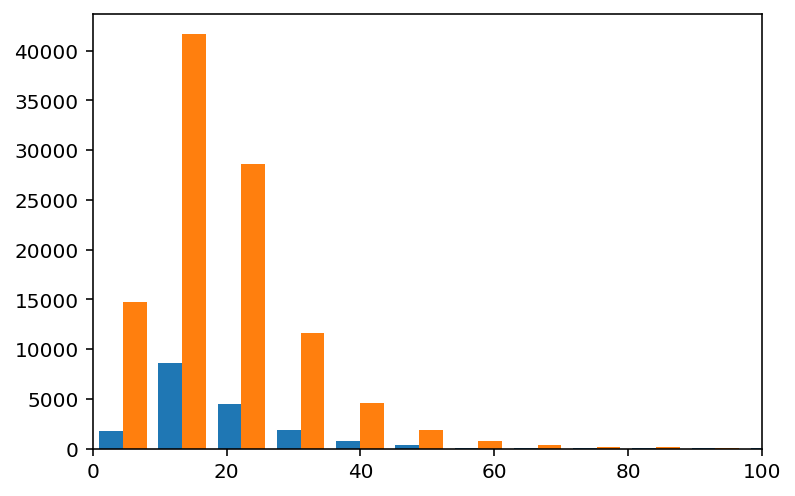

In [328]:
plt.hist([imputed[mask_nans], imputed_df['AFULA']],bins=100)

plt.xlim([0,100])
plt.show();

In [241]:
imputed[mask_nans]

array([28.63174545, 45.89626142, 40.80142235, ..., 18.13581055,
       22.477299  , 23.59725756])

In [242]:
# corrMatrix.sort_values()

In [243]:
imputed_df.head()

,AFULA,ANTOKOLSKY,HOLON,IRONID,KVISH4,REMEZ,YAD_LEBANIM,YEFET_YAFO,AHUZA_G,ATZMAUT_B,...,ORT,ROVA_TV,SDEROT,SDE_YOAV,YAHALOM,BEER_SHEVA,EAST_NEGEV,KFAR_MASARIK,PARDES_HANA,RAANANA
0,28.631745,28.100000,55.0,43.800000,45.896261,40.801422,19.677012,35.115001,17.8,31.2,...,39.2,39.2,45.7,35.1,52.400000,35.3,34.455832,9.30000,16.9,24.500696
1,41.195774,27.287042,55.0,39.596153,45.878480,37.849669,18.500000,34.284685,17.8,38.8,...,49.0,49.0,54.0,34.4,42.400000,33.1,30.674326,17.57453,16.9,27.020258
2,39.970434,27.700000,55.0,45.722279,47.146121,36.982329,21.700000,38.420524,16.2,43.3,...,43.8,43.8,48.0,44.9,43.174365,25.9,19.643383,20.20000,11.9,38.226212
3,25.151861,26.300000,64.6,48.700000,43.464360,44.238983,23.600000,36.708953,17.1,39.3,...,39.4,39.4,25.6,34.6,45.400000,26.4,24.175581,16.60000,15.1,39.900979
4,32.206326,28.000000,71.0,44.700000,33.990600,41.688247,25.000000,37.172076,18.3,37.1,...,42.5,42.5,20.3,26.0,35.100000,34.6,26.295005,14.40000,17.0,31.789568


In [421]:
np_imputed_df = imputed_df.values

In [439]:
# y_train = np_r_PM25_y[~np.isnan(np_r_PM25_y)]
# y_pred = np_imputed_df[~np.isnan(np_r_PM25_y)]

y_train = np_r_PM25_y[~np.isnan(np_r_PM25_y[:,0]),0]
y_pred = np_imputed_df[~np.isnan(np_r_PM25_y[:,0]),0]

In [440]:
y_train

array([19.4, 16.2, 20.7, ...,  5.1, 10.6, 18.9])

In [441]:
y_pred

array([18.64671762, 16.92619115, 16.54627719, ...,  9.05039156,
       19.60627627, 27.73720712])

In [442]:
# some indexes are not imputed for some reason:
not_imp_idx = np.argwhere(np.isnan(np_imputed_df))
not_imp_idx

array([[     0,      4],
       [     0,      5],
       [     0,      6],
       ...,
       [105165,     27],
       [105165,     28],
       [105165,     31]])

In [443]:
# y_train = y_train[~np.isnan(y_pred)]
# y_pred = y_pred[~np.isnan(y_pred)]

In [444]:

# assign results
RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)

[RMSE,MedianAE,MeanAE,R2]



[8.019208720623169, 3.9024184145976566, 5.080287282892301, 0.8648066082293426]

In [251]:
imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_my_KNN_090_cv10")

In [1142]:
# finding_k = []

In [1143]:
finding_k.append([k,RMSE,MedianAE,MeanAE,R2])

In [1146]:
finding_k

[[11,
  8.062258700593182,
  3.875107350960702,
  5.063837703643672,
  0.8633511791147962],
 [10,
  8.054800672215015,
  3.8852194604571118,
  5.0713033251569,
  0.8636038773836302],
 [9,
  8.019208720623169,
  3.9024184145976566,
  5.080287282892301,
  0.8648066082293426],
 [8,
  8.037534919423054,
  3.899835778165407,
  5.099594999712205,
  0.864187990594347],
 [7,
  8.074772243973879,
  3.905597616704661,
  5.120784577258408,
  0.8629266608653443],
 [12,
  8.066544663903374,
  3.8663236288542606,
  5.062049438093607,
  0.863205853213348]]

In [990]:
# imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_my_KNN_0857_cv10")

In [ ]:
# TRY WITH SHIFT 1 BACK AND SHIFT 1 FORWARD

# (3) ARIMA/LSTM/Prophet/the simplest ever for 1-? missing time-steps (short intervals)

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
# https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
# https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-lstm-vs-prophet-62241c203a3b

In [21]:
# ARIMA - use auto.arima...

import pmdarima
import statsmodels.tsa.api as smt

In [35]:
series = r_PM25_copy.iloc[:,0].values

In [51]:
start_index = 4676

series[4766]

5.4

In [36]:
np.split(imputed[:,0],np.where(np.isnan(series))[0])

[array([], dtype=float64),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan])

# (4) Run models 1-2 again with the short-interval imputed values

In [ ]:
# others
# https://impyute.readthedocs.io/en/latest/index.html
# https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
# statsmodels MICE - looks unclear... I need to give a formula..
# datawig 


# (5) Statistical imputation, just for comparison?

# (6) visualize results (box-plots + interactive time series+distribution of imputed values)

#### compare CV

In [379]:
# without days 
results_woD_BR = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_BR")
results_woD_RF = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_RF")
results_woD_KNN = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_KNN")
my_KNN_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv10")

In [390]:
# addition-1 dbda
RF_woD_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_woD_dbda_cv10")
my_KNN_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_dbda_cv10")

In [391]:
# addition-2
RF_wD_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_wD_dbda_cv10")

In [392]:
# my_KNN_cv10
np_values = my_KNN_cv10.values
y_train = np_r_PM25_y[~np.isnan(np_r_PM25_y)]
y_pred = np_values[~np.isnan(np_r_PM25_y)]

RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)

results_woD_My_KNN_CV10 = results_woD_KNN.copy() 

results_woD_My_KNN_CV10.iloc[9,:] = [RMSE,MedianAE,MeanAE,R2]
for i in range(9):
    results_woD_My_KNN_CV10.iloc[i,:] = [np.nan,np.nan,np.nan,np.nan]

In [397]:
# RF_woD_dbda_cv10 

np_values = RF_woD_dbda_cv10.values
y_train = np_r_PM25_y[~np.isnan(np_r_PM25_y)]
y_pred = np_values[~np.isnan(np_r_PM25_y)]

RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)

results_RF_woD_dbda_cv10 = results_woD_KNN.copy() 

results_RF_woD_dbda_cv10.iloc[9,:] = [RMSE,MedianAE,MeanAE,R2]
for i in range(9):
    results_RF_woD_dbda_cv10.iloc[i,:] = [np.nan,np.nan,np.nan,np.nan]

In [399]:
# my_KNN_dbda_cv10

np_values = my_KNN_dbda_cv10.values
y_train = np_r_PM25_y[~np.isnan(np_r_PM25_y)]
y_pred = np_values[~np.isnan(np_r_PM25_y)]

RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)

results_my_KNN_dbda_cv10 = results_woD_KNN.copy() 

results_my_KNN_dbda_cv10.iloc[9,:] = [RMSE,MedianAE,MeanAE,R2]
for i in range(9):
    results_my_KNN_dbda_cv10.iloc[i,:] = [np.nan,np.nan,np.nan,np.nan]

In [401]:
# RF_wD_dbda_cv10

np_values = RF_wD_dbda_cv10.values
y_train = np_r_PM25_y[~np.isnan(np_r_PM25_y)]
y_pred = np_values[~np.isnan(np_r_PM25_y)]

RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)

results_RF_wD_dbda_cv10 = results_woD_KNN.copy() 

results_RF_wD_dbda_cv10.iloc[9,:] = [RMSE,MedianAE,MeanAE,R2]
for i in range(9):
    results_RF_wD_dbda_cv10.iloc[i,:] = [np.nan,np.nan,np.nan,np.nan]

In [385]:
plt.rcParams.update(plt.rcParamsDefault)

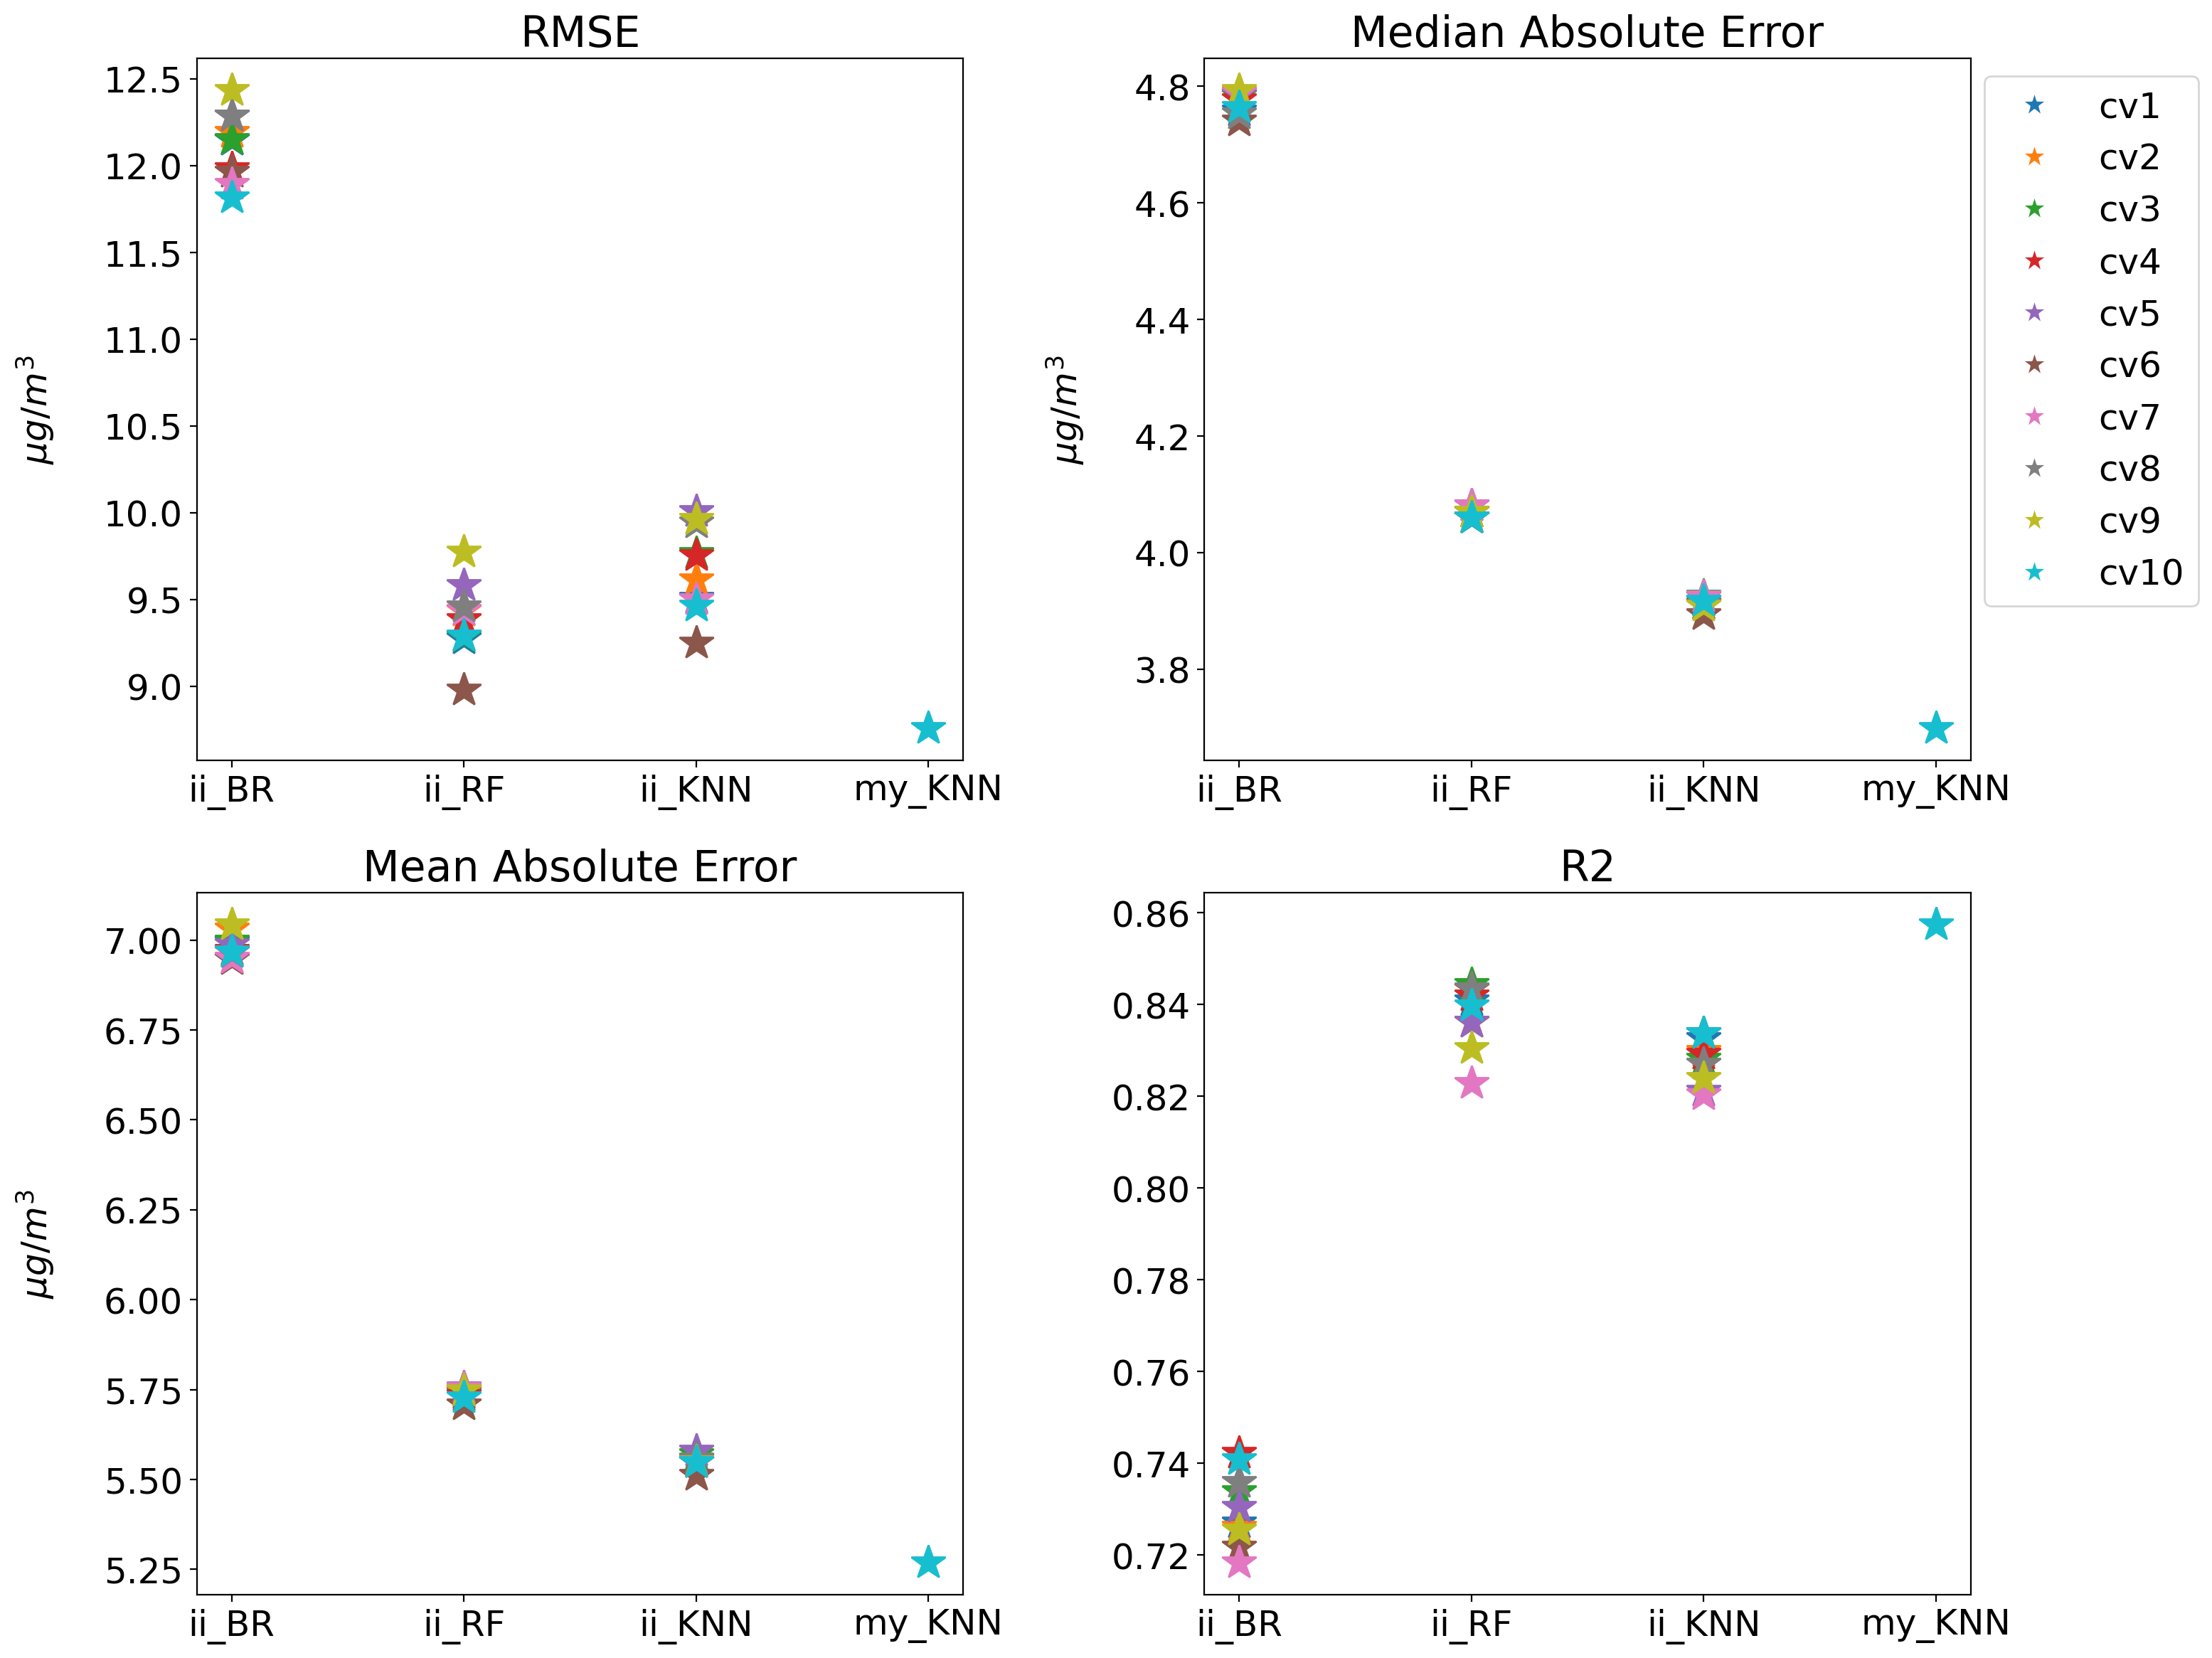

In [388]:
titles = ['RMSE','Median Absolute Error','Mean Absolute Error','R2']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,12))
# fig.suptitle('Cross-validation results')

N=10
cmap = plt.cm.tab10
col = cmap(np.linspace(0, 1, N))
rcParams['axes.prop_cycle'] = cycler(color=col)

ax1.plot(np.arange(0,4), [results_woD_BR.iloc[:,0],results_woD_RF.iloc[:,0],results_woD_KNN.iloc[:,0],results_woD_My_KNN_CV10.iloc[:,0]],'*') #RMSE
ax2.plot(np.arange(0,4), [results_woD_BR.iloc[:,1],results_woD_RF.iloc[:,1],results_woD_KNN.iloc[:,1],results_woD_My_KNN_CV10.iloc[:,1]],'*') # Median Absolute Error
ax3.plot(np.arange(0,4), [results_woD_BR.iloc[:,2],results_woD_RF.iloc[:,2],results_woD_KNN.iloc[:,2],results_woD_My_KNN_CV10.iloc[:,2]],'*') # Mean Absolute Error
ax4.plot(np.arange(0,4), [results_woD_BR.iloc[:,3],results_woD_RF.iloc[:,3],results_woD_KNN.iloc[:,3],results_woD_My_KNN_CV10.iloc[:,3]],'*') #r2

legend_elements = [Line2D([0], [0], marker='*', color='w', label='cv1',
                          markerfacecolor=col[0], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv2',
                          markerfacecolor=col[1], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv3',
                          markerfacecolor=col[2], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv4',
                          markerfacecolor=col[3], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv5',
                          markerfacecolor=col[4], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv6',
                          markerfacecolor=col[5], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv7',
                          markerfacecolor=col[6], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv8',
                          markerfacecolor=col[7], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv9',
                          markerfacecolor=col[8], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv10',
                          markerfacecolor=col[9], markersize=14)]

for i,ax in enumerate(fig.get_axes()):
    ax.set_title(titles[i])   
    ax.set_xticks(np.arange(0,4))
    ax.set_xticklabels(['ii_BR','ii_RF','ii_KNN','my_KNN'])
    if i!=3:
        ax.set_ylabel('$\mu g/m^3$\n')
    if i==1:
        ax.legend(handles=legend_elements,bbox_to_anchor=(1.32,1))
    
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'lines.markersize': 18})

plt.tight_layout()
# plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/CV_results_basic.png", dpi=500)
plt.show();

In [394]:
results_woD_BR
results_woD_RF
results_woD_KNN 
results_woD_My_KNN_CV10

,RMSE,MedianAE,MeanAE,R2
0,12.146577,4.757204,6.994312,0.727041
1,12.194144,4.789904,7.030386,0.726149
2,12.152302,4.783614,6.997097,0.733775
3,11.985335,4.777705,6.971577,0.742191
4,12.287126,4.785513,6.987615,0.730406
5,11.964026,4.740049,6.946813,0.721794
6,11.894747,4.788714,6.950691,0.718386
7,12.287924,4.753388,6.965011,0.735859
8,12.436219,4.793671,7.043854,0.725499
9,11.814214,4.763854,6.968005,0.740749


,RMSE,MedianAE,MeanAE,R2
0,9.276128,4.08,5.739155,0.840807
1,9.432850,4.06,5.744132,0.836131
2,9.288789,4.07,5.748222,0.844457
3,9.384672,4.07,5.732657,0.841935
4,9.580541,4.06,5.754636,0.836096
5,8.978527,4.06,5.708310,0.843317
6,9.436479,4.08,5.752286,0.822759
7,9.458052,4.06,5.748231,0.843511
8,9.773849,4.07,5.746742,0.830450
9,9.289947,4.06,5.728445,0.839699


,RMSE,MedianAE,MeanAE,R2
0,9.510036,3.917365,5.554462,0.832678
1,9.613944,3.911642,5.548207,0.829778
2,9.765258,3.925400,5.568478,0.828091
3,9.753575,3.911715,5.546650,0.829264
4,10.007616,3.922956,5.578250,0.821158
5,9.248886,3.893837,5.512880,0.833739
6,9.498568,3.923674,5.549481,0.820419
7,9.944436,3.911382,5.557848,0.827003
8,9.962109,3.908708,5.549101,0.823855
9,9.462517,3.916427,5.547056,0.833688


,RMSE,MedianAE,MeanAE,R2
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,8.759439,3.698848,5.269229,0.857484


In [402]:
results_RF_woD_dbda_cv10
results_my_KNN_dbda_cv10
results_RF_wD_dbda_cv10

,RMSE,MedianAE,MeanAE,R2
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,6.283847,2.61,3.878094,0.926656


,RMSE,MedianAE,MeanAE,R2
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,7.224003,2.913906,4.235449,0.903068


,RMSE,MedianAE,MeanAE,R2
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,6.271037,2.62,3.870339,0.926955


#### compare the time series (CV-10)

In [316]:
BR_woD_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/BR_woD_cv10")
RF_woD_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_woD_cv10")
KNN_woD_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/KNN_woD_cv10")
my_KNN_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv10")

# addition-1
RF_woD_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_woD_dbda_cv10")
my_KNN_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_dbda_cv10")

# addition-2
RF_wD_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_wD_dbda_cv10")

In [317]:
data_df = pd.concat([BR_woD_cv10, RF_woD_cv10, KNN_woD_cv10, my_KNN_cv10,RF_woD_dbda_cv10,my_KNN_dbda_cv10,RF_wD_dbda_cv10], keys=['BR', 'RF','KNN','my_KNN','RF_add1','my_KNN_add1','RF_add1+2'])

In [319]:
imputation_methods = ['BR', 'RF','KNN','my_KNN','RF_add1','my_KNN_add1','RF_add1+2']
len(imputation_methods)

7

In [320]:
# data_df.head()
# data_df.loc['BR']['AFULA']

In [321]:
# set extra colors in case more pollutants are measured in a station:
colors = ['#BC8F8F','blue','fuchsia','#BC8F8F','#8B4513','#2ca02c','#8B008B','#ff7f0e','#FFD700','LightSkyBlue']

color_lines = dict()
for im, c in zip(imputation_methods, colors[0:len(imputation_methods)+1]):
    color_lines[im] = c

In [312]:
# mark in background! the imputed without validation and in red background the validation.

In [325]:
def get_opposite_np_r_PM25_y():
    # generate np_r_PM25_y and modify it 
    r_PM25_copy = r_PM25.copy()
    np_r_PM25, np_r_PM25_y = return_X_y_KFold_cross_validation(r_PM25_copy,10)
    original_np_r_PM25_y = np_r_PM25_y.copy()
    np_r_PM25_y[np.isnan(np_r_PM25_y)] = -1
    np_r_PM25_y[np_r_PM25_y != -1 ] = np.nan
    return np_r_PM25_y, original_np_r_PM25_y
       

def get_missing_values_idx(missing_PM, Stations):
        
    missing_PM[missing_PM.notnull()] = 1
    missing_PM[missing_PM.isnull()] = 0
    diffs = missing_PM.diff(axis = 0)    
    #begining
    if missing_PM[Stations].iloc[0]==0:
        diffs[Stations].iloc[0]=-1

    #end
    if missing_PM[Stations].iloc[-1]==0:
        diffs[Stations].iloc[-1]=1

    row_start = np.where(diffs.loc[:,Stations] == -1)[0]
    row_end = np.where(diffs.loc[:,Stations] == 1)[0]

#     xranges = list(list(zip(row_start,row_end-row_start)))

    return row_start,row_end


def get_index(row_start, row_end):
    idx_x = np.array([])
    idx_y = np.array([])
    for rs,re in zip(row_start, row_end):  

        to_append_x = np.append(rs,np.append(np.arange(rs,re+1),re))
        idx_x=np.append(idx_x,to_append_x)

        to_append_y = np.append(0,np.append(np.ones((len(to_append_x)-2,))*1000,0))
        idx_y = np.append(idx_y,to_append_y)
    
    return idx_x.astype(int),idx_y    
    

In [323]:
# fig = go.Figure(go.Scatter(x=idx_x, y=idx_y, fill="tozeroy",mode = 'none'))
# fig.show()

In [328]:
layout = go.Layout(
    width = 700,
    height = 400,
    title={
        'text': "CV-10 results",
        'y':0.9,
        'x':0.5,
        'xanchor': 'right',
        'yanchor': 'top'},
    yaxis = dict(
        title = '$\mu g/m^3$ '
    ),
    xaxis = dict(
        title = 'Date'
    ),
    plot_bgcolor='rgb(255,255,250)'
#     paper_bgcolor = 'rgba(0,0,0,0)',
#     plot_bgcolor = 'rgba(0,0,0,0)'
)

def update_plot(Method,Stations):   

#     data = [] #empty list where all my traces are in
    fig = go.Figure(layout=layout)
        
    # imputed
    missing_PM = r_PM25.copy()
    row_start,row_end = get_missing_values_idx(missing_PM, Stations)
    idx_x, idx_y = get_index(row_start,row_end)
    
    fig.add_trace(go.Scattergl(
    x=times[idx_x],
    y=idx_y,
    mode = 'none',
    name = 'imputed',
    fillcolor='rgba(250,128,114, 0.5)',# the last value is opacity
    fill='tozeroy')) # fill down to xaxis
    
#     # validated
    np_r_PM25_y, original_np_r_PM25_y = get_opposite_np_r_PM25_y()
    r_PM25_y = pd.DataFrame(np_r_PM25_y,columns=r_PM25.columns)

    row_start,row_end = get_missing_values_idx(r_PM25_y, Stations)
    idx_x, idx_y = get_index(row_start,row_end)
    
    fig.add_trace(go.Scattergl(
    x=times[idx_x],
    y=idx_y,
    mode = 'none',
    name = 'validated',
    fillcolor='rgba(0,255,127, 0.5)',# the last value is opacity
    fill='tozeroy')) # fill down to xaxis
    
    # validated values 
    original_r_PM25_y = pd.DataFrame(original_np_r_PM25_y,columns=r_PM25.columns)
    d = original_r_PM25_y.loc[:,Stations]
     
    fig.add_trace(go.Scattergl(
    x=times,
    y=d,
    mode = 'markers',
    name = 'validation point',
    marker = dict(size=5,color='#FF0000')
    )) # fill down to xaxis


    
    for m in Method: # signals are the items in the multiselect widget    

        chosen_data = data_df.loc[m][Stations]
        
        # updaing imputation method
        fig.add_trace(go.Scattergl(
            x=times,
            y=chosen_data,
            mode = 'lines+markers',#lines/markers
            name = '{}\n{}'.format(m,Stations),
            opacity=.8,
            line = dict(width=0.5,color=color_lines[m]),
            marker = dict(size=4,color=color_lines[m]),
            showlegend = True
        ))

#     # if large data:
#     pio.write_html(fig, file='index.html', auto_open=True)
    # when using notebook
    py.offline.iplot(fig)
#     # if small data:
#     cpy.plot(fig, filename = 'cv_compare', auto_open=True)

i = widgets.interact(update_plot, 
             Stations = widgets.Dropdown(options=list(RF_woD_cv10.columns),description='Station'),
             Method = widgets.SelectMultiple(options=imputation_methods,value=('RF_add1+2',))
             )

interactive(children=(SelectMultiple(description='Method', index=(6,), options=('BR', 'RF', 'KNN', 'my_KNN', 'RF_add1', 'my_KNN_add1', 'RF_add1+2'), value=('RF_add1+2',)), Dropdown(description='Station', options=('AFULA', 'ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ', 'YAD_LEBANIM', 'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN', 'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM', 'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA'), value='AFULA'), Output()), _dom_classes=('widget-interact',))

In [ ]:
# trying with pyplot express and plotly chart:

In [282]:
# import plotly.express as px
# import chart_studio
# import chart_studio.plotly as cpy
# import plotly.io as pio

In [278]:
# username = 'iditbela' # your username
# api_key = 'znw1tfcxvG5gRUmiFjjq' # your api key - go to profile > settings > regenerate key
# chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [ ]:
# fig... 

In [286]:
        # cpy.plot(fig, filename = 'cv_compare', auto_open=True)

#### compare grouped by missing interval length

In [ ]:
# trash
s = pd.Series(tuple(map(tuple, not_nan_idx[test_index])))
vals = s.apply(lambda xy: r_PM25.iloc[xy[0],xy[1]])

In [178]:
PM25=r_PM25
k=2
withDays=False

kf = KFold(n_splits=k, random_state=0, shuffle=True)
not_nan_idx = np.argwhere(PM25.notnull().values)
results = []

In [179]:
for train_index, test_index in kf.split(not_nan_idx):
        train_index
        test_index

array([      1,       3,       4, ..., 1754019, 1754021, 1754024])

array([      0,       2,       6, ..., 1754023, 1754025, 1754026])

array([      0,       2,       6, ..., 1754023, 1754025, 1754026])

array([      1,       3,       4, ..., 1754019, 1754021, 1754024])

In [139]:
np_PM25 = PM25.values
X_missing = PM25.copy()
y_missing = PM25.copy()

# y_missing 
y_missing.iloc[:] = np.nan
np_y_missing = y_missing.values

# asssign values according to test indexes
rows, cols = zip(*not_nan_idx[test_index])
vals = np_PM25[rows, cols]
np_y_missing[rows, cols] = vals
# turn back to dataframe
y_missing = pd.DataFrame(np_y_missing,columns=PM25.columns)

# X_missing
# assign nans according to test indexes
np_X_missing = X_missing.values
np_X_missing[rows, cols] = np.nan

# turn back to dataframe
X_missing = pd.DataFrame(np_X_missing,columns=PM25.columns)

# mask all missing values
indicator = MissingIndicator(missing_values=np.nan)
mask_missing_values_original = indicator.fit_transform(PM25)
mask_missing_values_all = indicator.fit_transform(X_missing)

# perform fit 
imp.fit(X_missing)
imputed_df = imp.transform(X_missing) # impute it
imputed_df = pd.DataFrame(imputed_df, columns=X_missing.columns) #turn it from IterativeImputer object to a dataframe

[IterativeImputer] Completing matrix with shape (52606, 39)
[IterativeImputer] Change: 6112.810739330168, scaled tolerance: 1.133 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
                 max_iter=1, verbose=True)

[IterativeImputer] Completing matrix with shape (52606, 39)


In [180]:
# evaluate
# y_train = inverse_y_missing.values
y_train = vals

# y_pred = inverse_imputed_df.mask(~mask).values
np_imputed_df = imputed_df.values
y_pred = np_imputed_df[rows, cols]

In [181]:
y_train.shape
y_pred.shape

(877013,)

(877013,)

In [182]:
# assign results
RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)
# results.append([RMSE,MedianAE,MeanAE,R2])

In [183]:
# assign results
RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)
results.append([RMSE,MedianAE,MeanAE,R2])

In [184]:
results

[[12.065151202546158,
  4.540000000000001,
  6.837151125467923,
  0.5649296791889007]]

In [ ]:
# # do I need to sort all rows so I start with imputing the row with the smallest number 
# # of missing values? I think so. 

# # for i,row in enumerate(np_r_PM25):  
# #     # euclidean
# #     distance.cdist(np_r_PM25, row.reshape(-1, 1).T, lambda u, v: np.sqrt(np.nansum((u-v)**2)))
# #     print(i)
# # each chunk I get, is an array of all distances of row i with all other rows.
# # this is why in the first chunk 0 is first, in the second chunk 0 is second...
# # Once distances are calculated, we must sort all of the records in the training 
# # dataset by their distance to the new data (the desired row). 
# # We can then select the top k to return as the most similar neighbors. 


# def get_distance(all_data, imputed_row):

#     # when I want to compute it to all elements in the row, including nans:
#     dist = distance.cdist(all_data, imputed_row.reshape(-1, 1).T, lambda u, v: np.sqrt(np.nansum((u-v)**2)))
#     return dist
    
# # Locate the most similar neighbors of a row. 
# # all_data = np_r_PM25
# # imputed_row = the current row you want to impute. 

# def get_neighbors(all_data, imputed_row, num_neighbors):
#     dist = get_distance(all_data, imputed_row)
#     distances = list(zip(np_r_PM25, dist))    
#     distances.sort(key=lambda tup: tup[1])
#     neighbors = list()
#     for i in range(num_neighbors):
#         neighbors.append(distances[i][0])
#     return neighbors


# # # get_all_neighbors weigh all the neighbors. 
# # # so no need to sort
# # def get_all_neighbors(all_data, imputed_row):
# #     dist,no_elements = get_distance(all_data, imputed_row)
    
# #     distances = list(zip(np_r_PM25, dist, no_elements))

# #     return neighbors
    
 



# #     distance.cdist(np.delete(np_r_PM25, i,axis=0), row.reshape(-1, 1).T, lambda u, v: np.dot(u, v)/(np.linalg.norm(u)*np.linalg.norm(v)))
# #     distance.cdist(np.delete(np_r_PM25, i,axis=0), row.reshape(-1, 1).T, 'cosine') #euclidean

# # dot(a, b)/(norm(a)*norm(b))

In [ ]:
# # from the begining!
# def get_distance(row1, row2):   
#     cond = np.array((np.isnan(row1)) | (np.isnan(row2)))    
#     # divide the dist by the number of elements compared
#     dist = distance.cosine(row1[~cond],row2[~cond])/np.sum(~cond) #euclidean/cosine...
#     return dist

# def get_neighbors(all_data, imputed_row, num_neighbors):
#     distances = list()
#     weights = list()
#     for row in all_data:
#         dist = get_distance(imputed_row, row)
#         distances.append((row, dist))
#     distances.sort(key=lambda tup: tup[1])
#     neighbors = list() 
#     for i in range(num_neighbors):
#         neighbors.append(distances[i][0])
#         weights.append(distances[i][1])
#     return weights[1:], neighbors[1:] # don't return the imputed row itself

In [ ]:
# fig, ax = plt.subplots(figsize=(20,12))
# corrMatrix = r_PM25.corr()
# corrMatrix
# sns.heatmap(corrMatrix, annot=True)
# plt.show();